<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [121]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 100

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [122]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
from google.colab import auth
auth.authenticate_user()

In [124]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [125]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [126]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,109129,Discharged,2188-08-01 12:04:00
1,121510,Discharged,2133-04-23 15:52:00
2,106469,Discharged,2109-02-23 12:01:00
3,133732,Discharged,2167-10-16 13:13:00
4,119601,Discharged,2198-02-20 15:33:00
...,...,...,...
230665,147635,Entered ICU,2124-11-22 21:55:59
230666,167802,Entered ICU,2200-02-26 18:40:12
230667,186391,Entered ICU,2134-01-08 21:59:39
230668,156213,Entered ICU,2107-02-05 17:16:52


## Section 2: Process Discovery

In [127]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-127-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36881, 'Transfer': 5716, 'Discharged': 55}
End events: {'Discharged': 34688, 'Left ICU': 7947, 'Transfer': 14, 'Admitted': 3}


In [128]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [129]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 29340
Number of events: 160233
Start events: {'Admitted': 29340}
End events: {'Discharged': 29340}


In [130]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

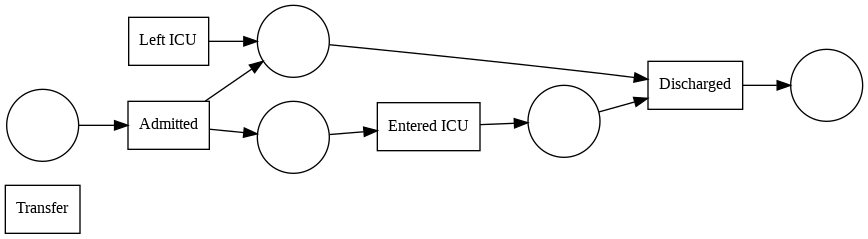

In [131]:
import graphviz
pm.view_petri_net(petri_net=net)

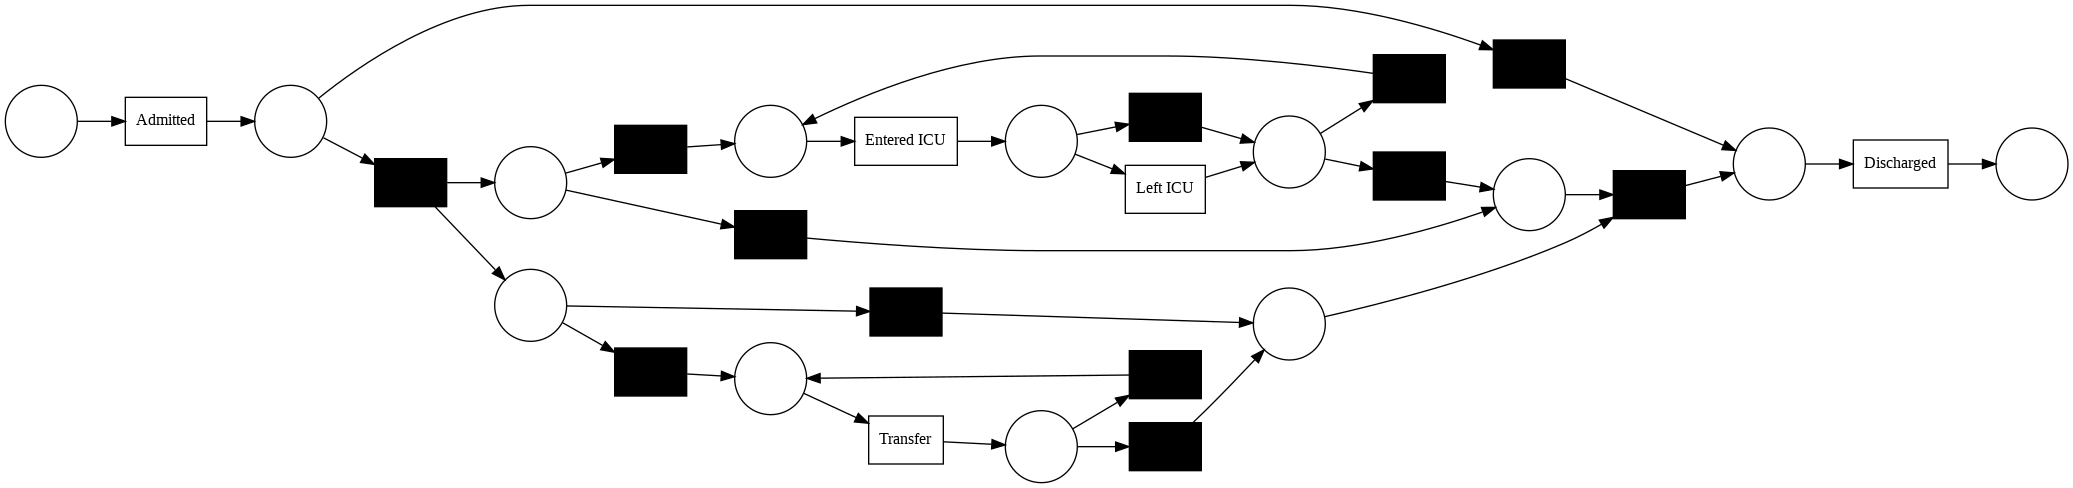

In [132]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

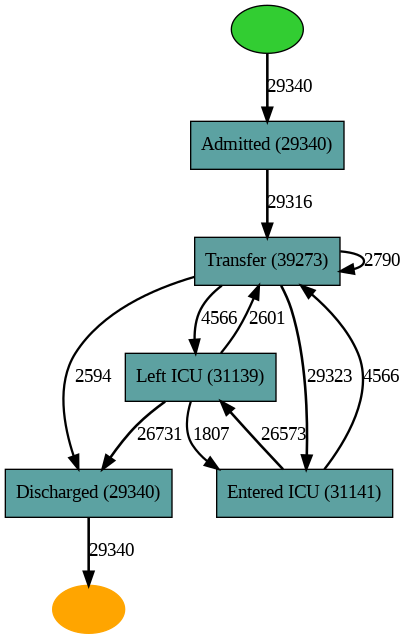

In [133]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

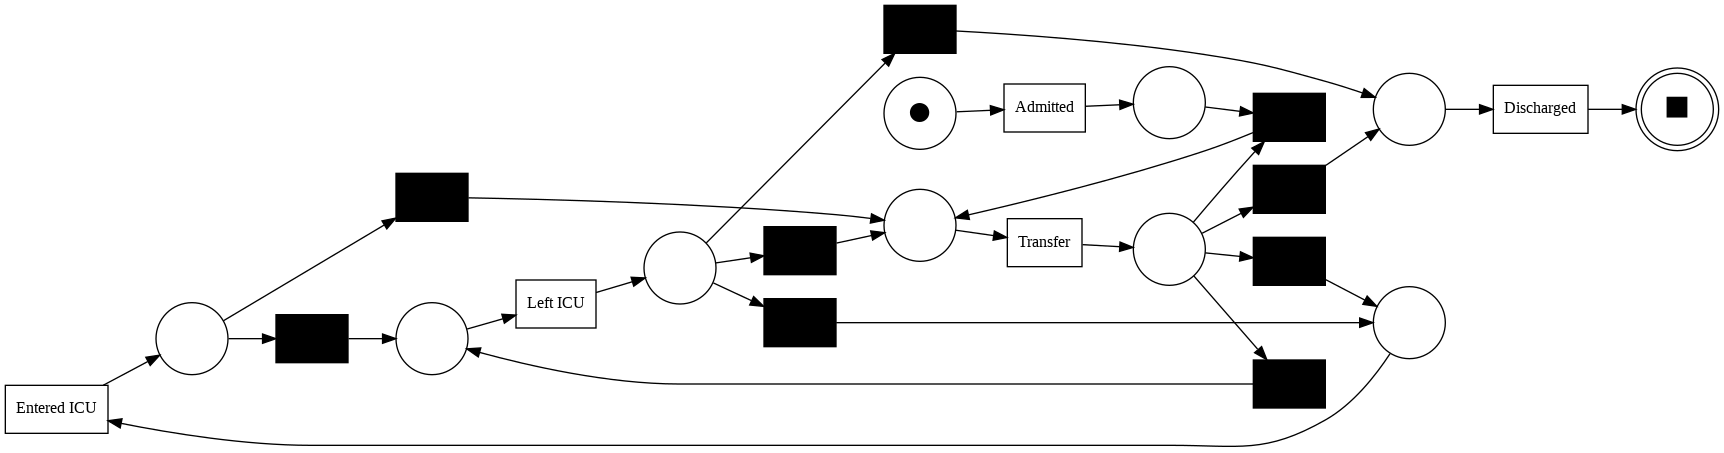

In [134]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

##Section 3: Preprocessing Data

In [135]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  # random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [136]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,trace,activity,timestamp
2459,447,Admitted,2154-07-28 21:47:00
2460,447,Transfer,2154-07-28 21:47:44
2461,447,Entered ICU,2154-07-28 21:47:44
2462,447,Left ICU,2154-07-29 13:36:18
2463,447,Discharged,2154-08-01 17:55:00
...,...,...,...
159670,29240,Transfer,2185-12-07 17:08:48
159671,29240,Transfer,2185-12-12 03:08:34
159672,29240,Entered ICU,2185-12-12 03:08:34
159673,29240,Left ICU,2185-12-15 20:25:38


In [137]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
12800,2341,Admitted,2170-01-22 18:19:00
12801,2341,Transfer,2170-01-22 18:20:10
12802,2341,Entered ICU,2170-01-30 17:59:50
12803,2341,Left ICU,2170-01-31 18:21:35
12804,2341,Transfer,2170-01-31 18:22:40
...,...,...,...
129141,23634,Admitted,2126-05-24 11:39:00
129142,23634,Transfer,2126-05-24 11:43:46
129143,23634,Entered ICU,2126-05-24 17:20:46
129144,23634,Left ICU,2126-06-06 12:24:45


In [138]:
import numpy as np
from copy import deepcopy

def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(0,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])
    print(df)

  return df, targets

In [139]:
test_x, test_y = random_remove(test_el)
test_x

      trace     activity           timestamp
12800  2341     Admitted 2170-01-22 18:19:00
12801  2341     Transfer 2170-01-22 18:20:10
12802  2341  Entered ICU 2170-01-30 17:59:50
12803  2341     Left ICU                 NaT
12804  2341     Transfer 2170-01-31 18:22:40
12805  2341   Discharged 2170-02-01 15:30:00
      trace     activity           timestamp
12800  2341     Admitted 2170-01-22 18:19:00
12801  2341     Transfer 2170-01-22 18:20:10
12802  2341  Entered ICU 2170-01-30 17:59:50
12803  2341     Left ICU                 NaT
12804  2341     Transfer 2170-01-31 18:22:40
12805  2341   Discharged 2170-02-01 15:30:00
17753  3246     Admitted 2195-04-30 23:19:00
17754  3246     Transfer                 NaT
17755  3246  Entered ICU 2195-05-01 22:26:01
17756  3246     Left ICU 2195-05-03 15:35:25
17757  3246   Discharged 2195-05-08 15:30:00
      trace     activity           timestamp
12800  2341     Admitted 2170-01-22 18:19:00
12801  2341     Transfer 2170-01-22 18:20:10
12802  234

,trace,activity,timestamp
12800,2341,Admitted,2170-01-22 18:19:00
12801,2341,Transfer,2170-01-22 18:20:10
12802,2341,Entered ICU,2170-01-30 17:59:50
12803,2341,Left ICU,NaT
12804,2341,Transfer,2170-01-31 18:22:40
...,...,...,...
129141,23634,Admitted,2126-05-24 11:39:00
129142,23634,Transfer,2126-05-24 11:43:46
129143,23634,Entered ICU,2126-05-24 17:20:46
129144,23634,Left ICU,2126-06-06 12:24:45


##Section 4: Predicting the correct sequence order

###4.1 Creating process model using training set

<ipython-input-166-ac7a42cbc91e>:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

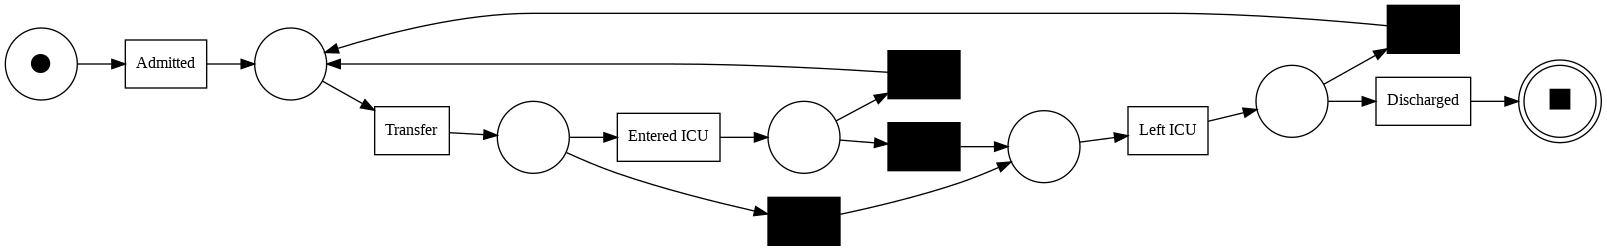

In [166]:
# format train event log as pm4py event log
train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
# petri net from heuristics miner
heuristic_net, heuristic_im, heuristic_fm = pm.discover_petri_net_heuristics(train_log, dependency_threshold=0.985)
pm.view_petri_net(heuristic_net, heuristic_im, heuristic_fm)

In [ ]:
inductive_net, inductive_im, inductive_fm = pm.discover_petri_net_inductive(train_log)
pm.view_petri_net(petri_net=inductive_net)

###4.2

In [162]:
def replay_trace(el):
  # log = pm.format_dataframe(el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
  replay_result = pm.fitness_token_based_replay(el, heuristic_net, heuristic_im, heuristic_fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  print(replay_result)
  return replay_result['average_trace_fitness']

In [163]:
def generate_traces(sequence, missing, trace):
    timestamps = sequence['timestamp'].tolist()
    if missing.iat[0,1] == 'Admitted':
      return pd.concat([missing,sequence], ignore_index=True)
    if missing.iat[0,1] == 'Discharged':
      return pd.concat([sequence,missing], ignore_index=True)
     
    # else generate permutations
    trace_length = len(timestamps) -1
    best_fitness = 0
    best_trace = None
    for i in range(1,trace_length):
      print('permuation: ', i)
      df = pd.concat([sequence.head(i), missing, sequence.tail(trace_length-i)], ignore_index=True)
      inputed_df = deepcopy(df)
      previous_timestamp = inputed_df.iat[i-1,2]
      next_timestamp = inputed_df.iat[i+1,2]
      inputed_timestamp = previous_timestamp + (next_timestamp-previous_timestamp)/2 
      inputed_df.iat[i,2] = inputed_timestamp
      fitness = replay_trace(inputed_df)
      # print(fitness)
      fitness = 1
      if fitness > best_fitness:
        best_fitness = fitness
        best_trace = df

    # for t in len 

    return best_trace


In [164]:
def predict_sequences(el):
  df = pd.DataFrame(columns=['trace','activity','timestamp'])
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    trace_df = el[:][test_el.trace == t]
    sequence = trace_df.loc[trace_df['timestamp'].notna()]
    missing = trace_df.loc[trace_df['timestamp'].isna()]

    
    predicted_trace = generate_traces(sequence, missing, t)
    df = pd.concat([df,predicted_trace], ignore_index=True)


  
  return df

predict_sequences(test_x)


permuation:  1
{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6666666666666667, 'log_fitness': 0.6666666666666667, 'percentage_of_fitting_traces': 0.0}
permuation:  2
{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.875, 'log_fitness': 0.875, 'percentage_of_fitting_traces': 0.0}
permuation:  3
{'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
permuation:  1
{'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
permuation:  2
{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6, 'log_fitness': 0.6, 'percentage_of_fitting_traces': 0.0}
permuation:  1
{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8333333333333334, 'log_fitness': 0.8333333333333334, 'percentage_of_fitting_traces': 0.0}
permuation:  2
{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8, 'log_fitness': 0.8, 'percentage_of_fitting_traces': 0.0}
permuation:  1
{'perc_fit_traces': 0.0,

,trace,activity,timestamp
0,2341,Admitted,2170-01-22 18:19:00
1,2341,Left ICU,NaT
2,2341,Entered ICU,2170-01-30 17:59:50
3,2341,Transfer,2170-01-31 18:22:40
4,2341,Discharged,2170-02-01 15:30:00
...,...,...,...
87,23634,Admitted,2126-05-24 11:39:00
88,23634,Transfer,2126-05-24 11:43:46
89,23634,Entered ICU,2126-05-24 17:20:46
90,23634,Left ICU,2126-06-06 12:24:45


In [ ]:
test_x

,trace,activity,timestamp
3448,626,Admitted,2116-07-19 21:07:00
3449,626,Transfer,2116-07-19 21:08:10
3450,626,Entered ICU,NaT
3451,626,Left ICU,2116-07-20 21:24:56
3452,626,Discharged,2116-07-22 16:00:00
...,...,...,...
155128,28406,Transfer,2174-01-28 05:57:53
155129,28406,Entered ICU,2174-01-28 05:57:53
155130,28406,Left ICU,NaT
155131,28406,Transfer,2174-02-03 14:43:42
